In [7]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet
from skimage.util import img_as_float
from skimage.morphology import reconstruction

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
skimage: 0.14dev


## Chan-Vese Segmentation

he Chan-Vese segmentation algorithm is designed to segment objects without clearly defined boundaries. This algorithm is based on level sets that are evolved iteratively to minimize an energy, which is defined by weighted values corresponding to the sum of differences intensity from the average value outside the segmented region, the sum of differences from the average value inside the segmented region, and a term which is dependent on the length of the boundary of the segmented region.

This algorithm was first proposed by Tony Chan and Luminita Vese, in a publication entitled “An Active Countour Model Without Edges”.

This implementation of the algorithm is somewhat simplified in the sense that the area factor ‘nu’ described in the original paper is not implemented, and is only suitable for grayscale images.

Typical values for lambda1 and lambda2 are 1. If the ‘background’ is very different from the segmented object in terms of distribution (for example, a uniform black image with figures of varying intensity), then these values should be different from each other.

Typical values for mu are between 0 and 1, though higher values can be used when dealing with shapes with very ill-defined contours.

The algorithm also returns a list of values that corresponds to the energy at each iteration. This can be used to adjust the various parameters described above.

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 7.51 s, sys: 0 ns, total: 7.51 s
Wall time: 7.52 s


/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


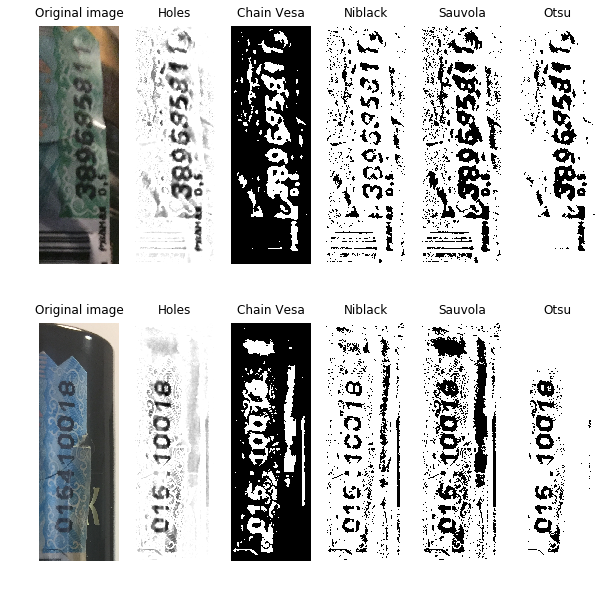

In [9]:
from skimage.segmentation import chan_vese
from skimage.filters import threshold_niblack, threshold_otsu, threshold_local, threshold_sauvola

src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled
%time cv = chan_vese(holes, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2
cv2 = chan_vese(holes2, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(holes, cmap='gray')
ax[1].set_title('Holes')
ax[1].axis('off')

ax[2].imshow(cv[0], cmap='gray')
ax[2].set_title('Chain Vesa')
ax[2].axis('off')

ax[3].imshow(holes > threshold_niblack(holes, window_size=91, k=0.9), cmap='gray')
ax[3].set_title('Niblack')
ax[3].axis('off')

ax[4].imshow(holes > threshold_sauvola(holes, window_size=155), cmap='gray')
ax[4].set_title('Sauvola')
ax[4].axis('off')

ax[5].imshow(holes > threshold_otsu(holes), cmap='gray')
ax[5].set_title('Otsu')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(holes2, cmap='gray')
ax[7].set_title('Holes')
ax[7].axis('off')

ax[8].imshow(cv2[0], cmap='gray')
ax[8].set_title('Chain Vesa')
ax[8].axis('off')

ax[9].imshow(holes2 > threshold_niblack(holes2, window_size=91, k=0.9), cmap='gray')
ax[9].set_title('Niblack')
ax[9].axis('off')

ax[10].imshow(holes2 > threshold_sauvola(holes2, window_size=155), cmap='gray')
ax[10].set_title('Sauvola')
ax[10].axis('off')

ax[11].imshow(holes2 > threshold_otsu(holes2), cmap='gray')
ax[11].set_title('Otsu')
ax[11].axis('off')

plt.show()

# Not so great result for 7!! seconds

## Random walker segmentation

The random walker algorithm determines the segmentation of an image from a set of markers labeling several phases (2 or more). An anisotropic diffusion equation is solved with tracers initiated at the markers’ position. The local diffusivity coefficient is greater if neighboring pixels have similar values, so that diffusion is difficult across high gradients. The label of each unknown pixel is attributed to the label of the known marker that has the highest probability to be reached first during this diffusion process.

In this example, two phases are clearly visible, but the data are too noisy to perform the segmentation from the histogram only. We determine markers of the two phases from the extreme tails of the histogram of gray values, and use the random walker for the segmentation.

## Hysteresis thresholding

*Hysteresis* is the lagging of an effect---a kind of inertia. In the
context of thresholding, it means that areas above some *low* threshold
are considered to be above the threshold *if* they are also connected
to areas above a higher, more stringent, threshold. They can thus be
seen as continuations of these high-confidence areas.

Below, we compare normal thresholding to hysteresis thresholding.
Notice how hysteresis allows one to ignore "noise" outside of the coin
edges.

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 3.11 ms
CPU times: user 863 ms, sys: 31.8 ms, total: 894 ms
Wall time: 894 ms


/home/levabd/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


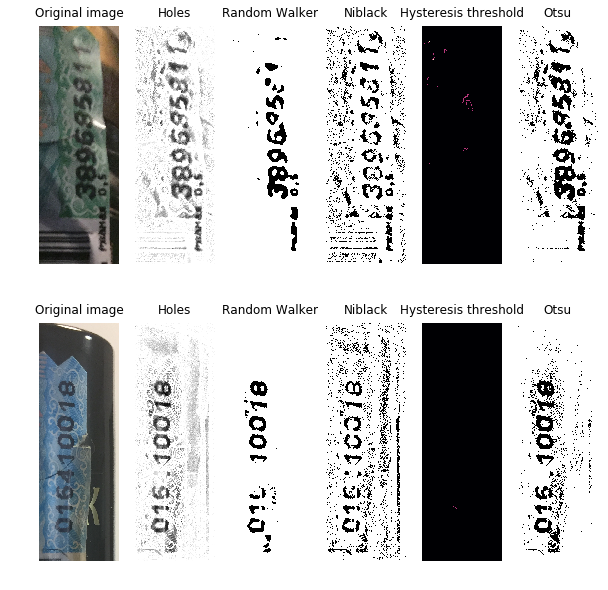

In [32]:
from skimage.segmentation import random_walker
from skimage.exposure import rescale_intensity
from skimage import data, filters

src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = img_log_clah#denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled
p2, p98 = np.percentile(holes, (2, 98))
%time data = rescale_intensity(holes, in_range=(p2, p98), out_range=(-1, 1))
# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2
%time labels = random_walker(data, markers, beta=10, mode='bf')

edges = filters.sobel(holes)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = img_log_clah#denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2
p2, p98 = np.percentile(holes2, (2, 98))
data = rescale_intensity(holes2, in_range=(p2, p98), out_range=(-1, 1))
# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers2 = np.zeros(data.shape, dtype=np.uint)
markers2[data < -0.95] = 1
markers2[data > 0.95] = 2
labels2 = random_walker(data, markers2, beta=10, mode='bf')

edges = filters.sobel(holes2)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight2 = (edges > high).astype(int)
hyst2 = filters.apply_hysteresis_threshold(edges, low, high)

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(holes, cmap='gray')
ax[1].set_title('Holes')
ax[1].axis('off')

ax[2].imshow(labels, cmap='gray', interpolation='nearest')
ax[2].set_title('Random Walker')
ax[2].axis('off')

ax[3].imshow(holes > threshold_niblack(holes, window_size=91, k=0.9), cmap='gray')
ax[3].set_title('Niblack')
ax[3].axis('off')

ax[4].imshow(hight + hyst, cmap='magma')
ax[4].set_title('Hysteresis threshold')
ax[4].axis('off')

ax[5].imshow(holes > threshold_otsu(holes), cmap='gray')
ax[5].set_title('Otsu')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(holes2, cmap='gray')
ax[7].set_title('Holes')
ax[7].axis('off')

ax[8].imshow(labels2, cmap='gray', interpolation='nearest')
ax[8].set_title('Random Walker')
ax[8].axis('off')

ax[9].imshow(holes2 > threshold_niblack(holes2, window_size=91, k=0.9), cmap='gray')
ax[9].set_title('Niblack')
ax[9].axis('off')

ax[10].imshow(hight2 + hyst2, cmap='magma')
ax[10].set_title('Hysteresis threshold')
ax[10].axis('off')

ax[11].imshow(holes2 > threshold_otsu(holes2), cmap='gray')
ax[11].set_title('Otsu')
ax[11].axis('off')

plt.show()

# !!! One of the great and fast result. Like Niblack

## Try 4 most popular low-level segmentation methods

As it is difficult to obtain good segmentations, and the definition of “good” often depends on the application, these methods are usually used for obtaining an oversegmentation, also known as superpixels. These superpixels then serve as a basis for more sophisticated algorithms such as conditional random fields (CRF).

## Felzenszwalb’s efficient graph based segmentation
This fast 2D image segmentation algorithm, proposed in [1] is popular in the computer vision community. The algorithm has a single scale parameter that influences the segment size. The actual size and number of segments can vary greatly, depending on local contrast.

[1]	Efficient graph-based image segmentation, Felzenszwalb, P.F. and Huttenlocher, D.P. International Journal of Computer Vision, 2004

## Quickshift image segmentation
Quickshift is a relatively recent 2D image segmentation algorithm, based on an approximation of kernelized mean-shift. Therefore it belongs to the family of local mode-seeking algorithms and is applied to the 5D space consisting of color information and image location [2].

One of the benefits of quickshift is that it actually computes a hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: sigma controls the scale of the local density approximation, max_dist selects a level in the hierarchical segmentation that is produced. There is also a trade-off between distance in color-space and distance in image-space, given by ratio.

[2]	Quick shift and kernel methods for mode seeking, Vedaldi, A. and Soatto, S. European Conference on Computer Vision, 2008

## SLIC - K-Means based image segmentation
This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient. It is essential for this algorithm to work in Lab color space to obtain good results. The algorithm quickly gained momentum and is now widely used. See [3] for details. The compactness parameter trades off color-similarity and proximity, as in the case of Quickshift, while n_segments chooses the number of centers for kmeans.

[3]	Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi, Pascal Fua, and Sabine Suesstrunk, SLIC Superpixels Compared to State-of-the-art Superpixel Methods, TPAMI, May 2012.

## Compact watershed segmentation of gradient images
Instead of taking a color image as input, watershed requires a grayscale gradient image, where bright pixels denote a boundary between regions. The algorithm views the image as a landscape, with bright pixels forming high peaks. This landscape is then flooded from the given markers, until separate flood basins meet at the peaks. Each distinct basin then forms a different image segment. [4]

As with SLIC, there is an additional compactness argument that makes it harder for markers to flood faraway pixels. This makes the watershed regions more regularly shaped. 

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Felzenszwalb number of segments: 364
SLIC number of segments: 4
Quickshift number of segments: 500


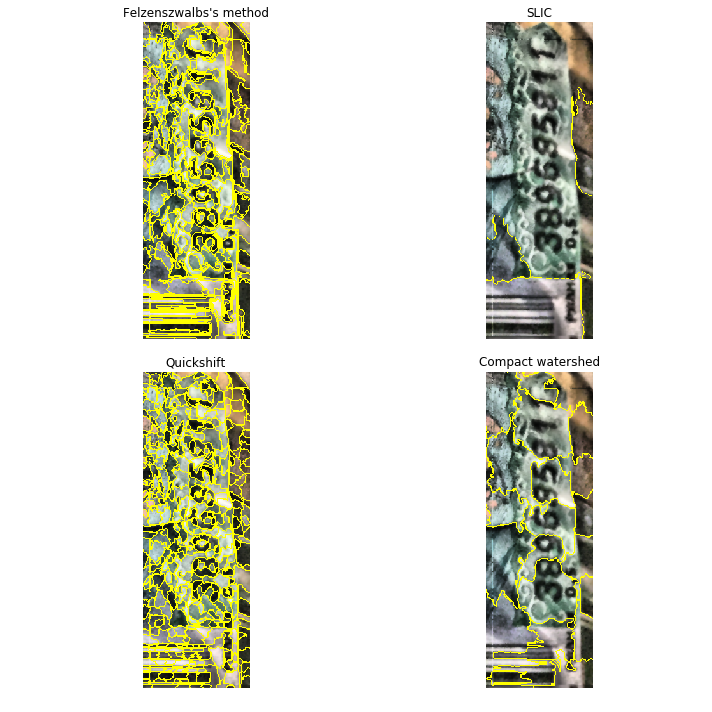

CPU times: user 2.48 s, sys: 390 ms, total: 2.87 s
Wall time: 2.39 s


In [12]:
%%time

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]
image = image.resize(((int)(width * 500 / height), 500), Image.ANTIALIAS)

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
# pixels = np.asarray(((denoised.getdata())))

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

# img = img_as_float(astronaut()[::2, ::2])
# img = img_as_float(pixels)

segments_fz = felzenszwalb(denoised, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(denoised, n_segments=20, compactness=10, sigma=1)
segments_quick = quickshift(denoised, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(denoised))
segments_watershed = watershed(gradient, markers=20, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(denoised, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(denoised, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(denoised, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(denoised, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Felzenszwalb has good result to segment digits, but has too many bad regions

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


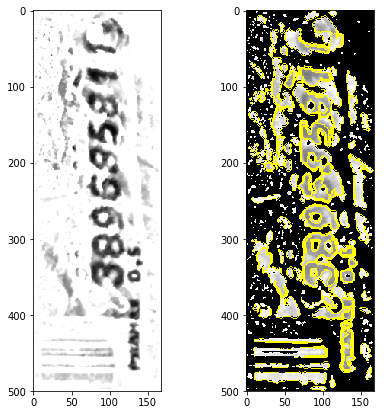

CPU times: user 751 ms, sys: 309 ms, total: 1.06 s
Wall time: 654 ms


In [22]:
%%time

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]
image = image.resize(((int)(width * 500 / height), 500), Image.ANTIALIAS)

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled
segments_fz = felzenszwalb(holes, scale=100, sigma=0.5, min_size=50)
# fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(holes, cmap='gray')
ax[1].imshow(mark_boundaries(holes, segments_fz))

plt.show()


## Active Contour Model


The active contour model is a method to fit open or closed splines to lines or
edges in an image [1]_. It works by minimising an energy that is in part
defined by the image and part by the spline's shape: length and smoothness. The
minimization is done implicitly in the shape energy and explicitly in the
image energy.

In the following two examples the active contour model is used (1) to segment
the face of a person from the rest of an image by fitting a closed curve
to the edges of the face and (2) to find the darkest curve between two fixed
points while obeying smoothness considerations. Typically it is a good idea to
smooth images a bit before analyzing, as done in the following examples.

We initialize a circle around the astronaut's face and use the default boundary
condition ``bc='periodic'`` to fit a closed curve. The default parameters
``w_line=0, w_edge=1`` will make the curve search towards edges, such as the
boundaries of the face.

.. [1] *Snakes: Active contour models*. Kass, M.; Witkin, A.; Terzopoulos, D.
       International Journal of Computer Vision 1 (4): 321 (1988).

![](https://camo.githubusercontent.com/eed709a8c7285ecae36ccaeca0e6a282d15c1e70/68747470733a2f2f7261772e6769746875622e636f6d2f706d6e65696c612f6d6f727068736e616b65732f6d61737465722f6578616d706c65732f6c616b65732e676966)

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


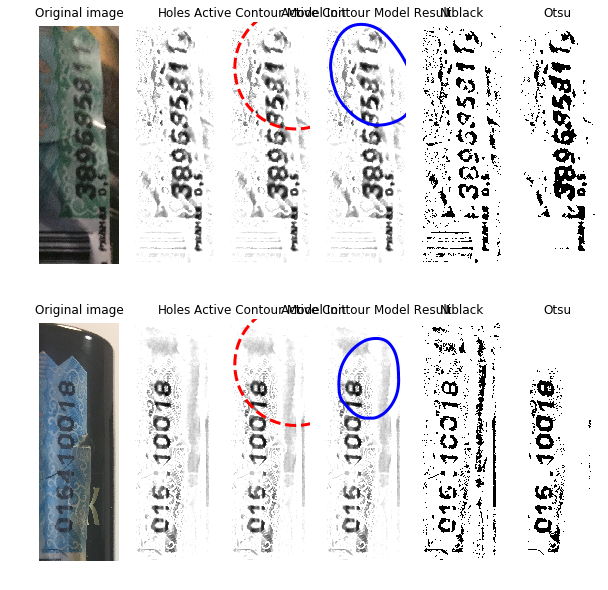

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled

s = np.linspace(0, 2*np.pi, 400)
x = 320 + 300*np.cos(s)
y = 200 + 300*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(holes, init, alpha=0.015, beta=10, gamma=0.001)

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2

s = np.linspace(0, 2*np.pi, 400)
x = 320 + 300*np.cos(s)
y = 200 + 300*np.sin(s)
init2 = np.array([x, y]).T

snake2 = active_contour(holes2, init2, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(holes, cmap='gray')
ax[1].set_title('Holes')
ax[1].axis('off')

ax[2].imshow(holes, cmap='gray')
ax[2].plot(init[:, 0], init[:, 1], '--r', lw=3)
ax[2].set_title('Active Contour Model Init')
ax[2].axis('off')

ax[3].imshow(holes, cmap='gray')
ax[3].plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax[3].set_title('Active Contour Model Result')
ax[3].axis('off')

ax[4].imshow(holes > threshold_niblack(holes, window_size=91, k=0.9), cmap='gray')
ax[4].set_title('Niblack')
ax[4].axis('off')

ax[5].imshow(holes > threshold_otsu(holes), cmap='gray')
ax[5].set_title('Otsu')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(holes2, cmap='gray')
ax[7].set_title('Holes')
ax[7].axis('off')

ax[8].imshow(holes2, cmap='gray', interpolation='nearest')
ax[8].plot(init2[:, 0], init2[:, 1], '--r', lw=3)
ax[8].set_title('Active Contour Model Init')
ax[8].axis('off')

ax[9].imshow(holes2, cmap='gray')
ax[9].plot(snake2[:, 0], snake2[:, 1], '-b', lw=3)
ax[9].set_title('Active Contour Model Result')
ax[9].axis('off')

ax[10].imshow(holes2 > threshold_niblack(holes2, window_size=91, k=0.9), cmap='gray')
ax[10].set_title('Niblack')
ax[10].axis('off')

ax[11].imshow(holes2 > threshold_otsu(holes2), cmap='gray')
ax[11].set_title('Otsu')
ax[11].axis('off')

plt.show()

## We need to go deeper

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


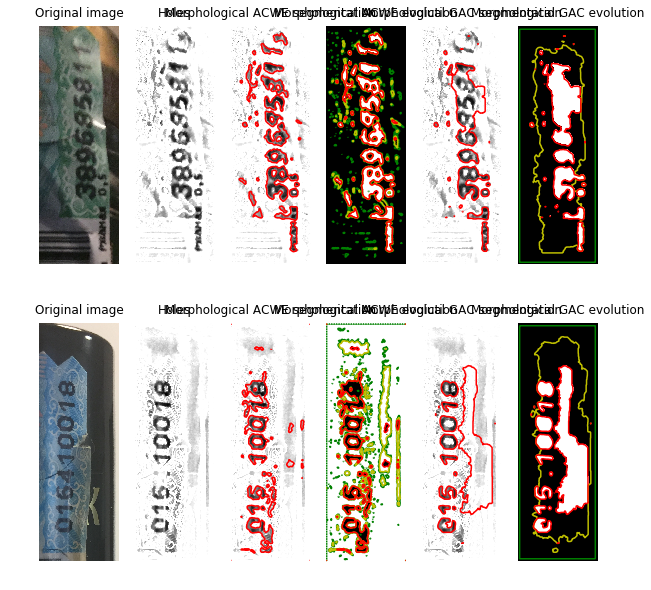

In [29]:
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled

# Initial level set
init_ls = checkerboard_level_set(holes.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(holes, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

# Morphological GAC
gimage = inverse_gaussian_gradient(holes)

# Initial level set
init_ls = np.zeros(holes.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution3 = []
callback3 = store_evolution_in(evolution3)
ls3 = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback3)

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2

# Initial level set
init_ls2 = checkerboard_level_set(holes2.shape, 6)
# List with intermediate results for plotting the evolution
evolution2 = []
callback2 = store_evolution_in(evolution2)
ls2 = morphological_chan_vese(holes2, 35, init_level_set=init_ls2, smoothing=3,
                             iter_callback=callback2)

# Morphological GAC
gimage2 = inverse_gaussian_gradient(holes2)

# Initial level set
init_ls2 = np.zeros(holes2.shape, dtype=np.int8)
init_ls2[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution4 = []
callback4 = store_evolution_in(evolution4)
ls4 = morphological_geodesic_active_contour(gimage2, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback4)

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(holes, cmap='gray')
ax[1].set_title('Holes')
ax[1].axis('off')

ax[2].imshow(holes, cmap='gray')
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title('Morphological ACWE segmentation')
ax[2].axis('off')

ax[3].imshow(ls, cmap='gray')
contour = ax[3].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[3].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[3].set_title('Morphological ACWE evolution')
ax[3].axis('off')

ax[4].imshow(holes, cmap='gray')
ax[4].contour(ls3, [0.5], colors='r')
ax[4].set_title('Morphological GAC segmentation')
ax[4].axis('off')

ax[5].imshow(ls3, cmap='gray')
contour3 = ax[5].contour(evolution3[0], [0.5], colors='g')
contour3.collections[0].set_label("Iteration 0")
contour3 = ax[5].contour(evolution3[100], [0.5], colors='y')
contour3.collections[0].set_label("Iteration 100")
contour3 = ax[5].contour(evolution3[-1], [0.5], colors='r')
contour3.collections[0].set_label("Iteration 230")
ax[5].set_title('Morphological GAC evolution')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(holes2, cmap='gray')
ax[7].set_title('Holes')
ax[7].axis('off')

ax[8].imshow(holes2, cmap='gray', interpolation='nearest')
ax[8].contour(ls2, [0.5], colors='r')
ax[8].set_title('Morphological ACWE segmentation')
ax[8].axis('off')

ax[9].imshow(ls2, cmap='gray')
contour2 = ax[9].contour(evolution2[2], [0.5], colors='g')
contour2.collections[0].set_label("Iteration 2")
contour2 = ax[9].contour(evolution2[7], [0.5], colors='y')
contour2.collections[0].set_label("Iteration 7")
contour2 = ax[9].contour(evolution2[-1], [0.5], colors='r')
contour2.collections[0].set_label("Iteration 35")
ax[9].set_title('Morphological ACWE evolution')
ax[9].axis('off')

ax[10].imshow(holes2, cmap='gray')
ax[10].contour(ls4, [0.5], colors='r')
ax[10].set_title('Morphological GAC segmentation')
ax[10].axis('off')

ax[11].imshow(ls4, cmap='gray')
contour4 = ax[11].contour(evolution4[0], [0.5], colors='g')
contour4.collections[0].set_label("Iteration 0")
contour4 = ax[11].contour(evolution4[100], [0.5], colors='y')
contour4.collections[0].set_label("Iteration 100")
contour4 = ax[11].contour(evolution4[-1], [0.5], colors='r')
contour4.collections[0].set_label("Iteration 230")
ax[11].set_title('Morphological GAC evolution')
ax[11].axis('off')

plt.show()